In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pymongo
import pickle
import string
import nltk
import re
import os
import sys
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')



src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

# helper functions
from d02_processing.cleaning_signatures import sorted_signatures
from d02_processing.cleaning_signatures import cleaned_signatures
from d01_utils.mongo_cursor_creator import mongo_cursor

# Load the "autoreload" extension
%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

%matplotlib inline

### Clean up and play with a small data set to make it work for the models

In [3]:
df = pd.read_csv('../../data/02_intermediate/cleaned_and_sorted.csv')
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.head()

,curl_pattern,density,porosity,texture,products
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...
1,3b,thick,NaN,NaN,since feb 09 currently using low poo tj s nour...
2,NaN,NaN,high,fine,dense normal to modified for washing and deta...
3,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...
4,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...


## Run Models

In [23]:
products_df = pd.read_csv('../../data/02_intermediate/relevant_products.csv')
products_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
print(products_df.size)
products_df.head(20)

21840


,curl_pattern,density,porosity,texture,products,relevant_products
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl
1,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,love shea seed
2,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
3,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
6,4a,NaN,NaN,NaN,demcalicurls hair type big chop june 2006 rel...,redken
7,2b,thin,NaN,NaN,former then modified now too lazy p type i k a...,NaN
8,3a,thin,NaN,NaN,former then modified now too lazy p type i k a...,NaN
9,NaN,thick,low,medium,hair type wavy normal elasticity,NaN


In [32]:
products_df.dropna(axis=0, how='any', subset=['relevant_products'], inplace=True)
print(products_df.shape)
products_df.head(20)

(2302, 6)


,curl_pattern,density,porosity,texture,products,relevant_products
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl
1,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,love shea seed
2,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
3,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
6,4a,NaN,NaN,NaN,demcalicurls hair type big chop june 2006 rel...,redken
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl


In [22]:
products_df.relevant_products.value_counts()

not                                    100
love                                    87
suave                                   84
as                                      71
shea                                    62
kinky                                   47
grow                                    44
mixed                                   43
giovanni                                36
devacurl                                32
tresemme                                26
every                                   24
jessicurl                               21
shea suave                              21
aussie                                  19
herbal                                  17
la                                      16
got                                     15
ag                                      15
la suave                                15
suave aussie                            14
shea as                                 13
american                                13
vo5        

In [18]:

#Using sklearn.feature_extraction.text.CountVectorizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.DataFrame({'text': [['hello', 'world'], 
                        ['hello', 'stackoverflow', 'hello']]
                   })

## Join words to a single line as required by CountVectorizer
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))

In [45]:
x

<2302x79 sparse matrix of type '<class 'numpy.int64'>'
	with 4949 stored elements in Compressed Sparse Row format>

In [31]:
products_df.shape

(2302, 6)

In [157]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(products_df['relevant_products'].values)
list_of_vectors= x.toarray()
feature_names = list(vectorizer.get_feature_names())
print(feature_names)
print(list_of_vectors[0])


['ag', 'alterna', 'american', 'aquage', 'as', 'aussie', 'biosilk', 'briogeo', 'bumble', 'cake', 'carol', 'curlsmith', 'design', 'devacurl', 'every', 'fairy', 'flax', 'frank', 'frederick', 'fruit', 'giovanni', 'got', 'grow', 'hask', 'herbal', 'house', 'jack', 'jessicurl', 'john', 'joico', 'kenra', 'keratin', 'kiehl', 'kinky', 'klorane', 'la', 'lime', 'living', 'loreal', 'love', 'macadamia', 'mane', 'marc', 'matrix', 'maui', 'mixed', 'mizani', 'nexxus', 'nioxin', 'not', 'noughty', 'ogx', 'ouidad', 'paul', 'philosophy', 'phyto', 'pravana', 'pura', 'pureology', 'redken', 'rusk', 'sebastian', 'seed', 'sexy', 'shea', 'sheamoisture', 'shimmer', 'soap', 'socozy', 'suave', 'sun', 'system', 'tgin', 'tigi', 'tresemme', 'ulta', 'vo5', 'wella', 'yes']
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0]


In [158]:
# vector_list = []
# for x in range(len(list_of_vectors)):
#     vector_list.append(str(list_of_vectors[x]))
vector_df = pd.DataFrame(list_of_vectors)
vector_df.columns = feature_names
vector_df.head()

,ag,alterna,american,aquage,as,aussie,biosilk,briogeo,bumble,cake,...,suave,sun,system,tgin,tigi,tresemme,ulta,vo5,wella,yes
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [164]:
vector_df.sum(axis=0).sort_values(ascending=False)

suave           500
shea            359
as              303
love            269
giovanni        240
not             234
vo5             172
tresemme        164
la              164
herbal          155
devacurl        152
kinky           149
mixed           141
jessicurl       135
aussie          134
every           112
ag              100
grow             99
yes              61
tigi             54
sheamoisture     53
seed             51
soap             50
ouidad           50
got              49
loreal           46
keratin          45
redken           41
paul             37
john             33
               ... 
design            8
fairy             7
curlsmith         7
shimmer           7
maui              7
mizani            6
nioxin            6
sebastian         5
jack              5
alterna           5
tgin              4
macadamia         4
ogx               3
briogeo           3
marc              3
ulta              2
pravana           2
frederick         2
rusk              2


In [56]:
products_with_vecs = pd.concat([products_df,vector_df], ignore_index=True, axis=1)
products_with_vecs.head()

,0,1,2,3,4,5,6
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0...
1,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,love shea seed,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
2,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
3,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as,[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...


### Curl Pattern Model 

In [118]:
products_df.curl_pattern.value_counts()

3a    574
3b    394
2c    328
3c    244
2b    229
4a    216
2a    101
4b     51
4c     10
1c      7
Name: curl_pattern, dtype: int64

In [61]:
clean_pattern_products_df = products_df.dropna(axis=0, how='any', subset=['curl_pattern'])
print(clean_pattern_products_df.shape)
clean_pattern_products_df.head(20)

(2154, 6)


,curl_pattern,density,porosity,texture,products,relevant_products
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl
1,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,love shea seed
2,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
3,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
6,4a,NaN,NaN,NaN,demcalicurls hair type big chop june 2006 rel...,redken
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl


In [119]:

clean_pattern_products_df['curl_catagory'] = pd.Categorical(clean_pattern_products_df.curl_pattern)
clean_pattern_products_df["curl_catagory"] = clean_pattern_products_df["curl_catagory"].cat.codes
print(clean_pattern_products_df.describe())
clean_pattern_products_df.head()

       curl_catagory
count    2154.000000
mean        4.309656
std         1.729294
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         9.000000


,curl_pattern,density,porosity,texture,products,relevant_products,curl_catagory
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl,2
1,4a,NaN,NaN,NaN,deeplyenrichedoils com show me some love check...,love shea seed,7
2,3a,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun,4
3,3b,NaN,NaN,NaN,hair type and lots of it hair color ranges fro...,sun,5
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as,3


In [120]:


curl_catagory_df = clean_pattern_products_df[['curl_pattern', 'curl_catagory']].drop_duplicates().sort_values('curl_catagory')
curl_cat_key_dict = dict(curl_catagory_df.values)
curl_pattern_key_dict = dict(curl_catagory_df[['curl_catagory', 'curl_pattern']].values)
print(curl_cat_key_dict)
print(curl_pattern_key_dict)
curl_catagory_df

{'1c': 0, '2a': 1, '2b': 2, '2c': 3, '3a': 4, '3b': 5, '3c': 6, '4a': 7, '4b': 8, '4c': 9}
{0: '1c', 1: '2a', 2: '2b', 3: '2c', 4: '3a', 5: '3b', 6: '3c', 7: '4a', 8: '4b', 9: '4c'}


,curl_pattern,curl_catagory
320,1c,0
38,2a,1
0,2b,2
4,2c,3
2,3a,4
3,3b,5
23,3c,6
1,4a,7
50,4b,8
1064,4c,9


In [121]:
X_train, X_test, y_train, y_test = train_test_split(clean_pattern_products_df['relevant_products'], clean_pattern_products_df['curl_pattern'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
features = count_vect.fit_transform(clean_pattern_products_df.relevant_products).toarray()
labels = clean_pattern_products_df.curl_pattern

In [125]:

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    f1 = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, f1s in enumerate(f1):
        entries.append((model_name, fold_idx, f1s))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])
cv_df.groupby('model_name').f1.mean()

model_name
LinearSVC                 0.167835
LogisticRegression        0.168838
MultinomialNB             0.154080
RandomForestClassifier    0.112930
Name: f1, dtype: float64

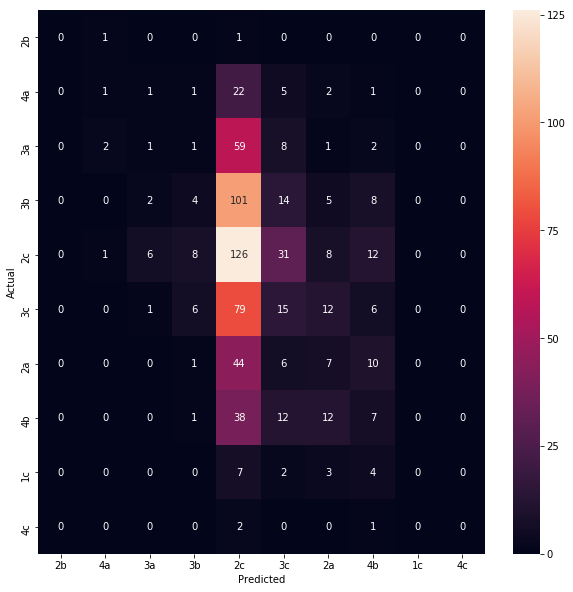

In [128]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=clean_pattern_products_df.curl_pattern.unique(), yticklabels=clean_pattern_products_df.curl_pattern.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('../../results/curl_pattern.png')
plt.show()

In [79]:
clean_pattern_products_df.curl_pattern.unique()

array(['2b', '4a', '3a', '3b', '2c', '3c', '2a', '4b', '1c', '4c'],
      dtype=object)

In [ ]:
clean_pattern_products_df = products_df.dropna(axis=0, how='any', subset=['curl_pattern'])
print(clean_pattern_products_df.shape)
clean_pattern_products_df.head(20)

### Texture Pattern Model 

In [81]:
clean_texture_products_df = products_df.dropna(axis=0, how='any', subset=['texture'])
print(clean_texture_products_df.shape)
clean_texture_products_df.head(20)

(763, 6)


,curl_pattern,density,porosity,texture,products,relevant_products
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl
17,3b,thick,low,coarse,my hair strands virgin hair armpit length cu...,tresemme
25,3a,thick,normal,medium,co wash suave naturals lavender co rinse natu...,suave aussie
33,3b,NaN,NaN,fine,naturally curly hair new hairstyle is now a m...,redken
35,3a,NaN,NaN,fine,public fotki com jackiecoh 91908 pw curls curl...,devacurl


In [82]:

clean_texture_products_df['texture_catagory'] = pd.Categorical(clean_texture_products_df.texture)
clean_texture_products_df["texture_catagory"] = clean_texture_products_df["texture_catagory"].cat.codes
print(clean_texture_products_df.describe())
clean_texture_products_df.head()

       texture_catagory
count        763.000000
mean           1.125819
std            0.463810
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            2.000000


,curl_pattern,density,porosity,texture,products,relevant_products,texture_catagory
0,2b,NaN,NaN,coarse,poo deva nopoo co wash suave naturals rinse ou...,suave devacurl,0
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as,1
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as,1
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living,1
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living,1


In [133]:


texture_catagory_df = clean_texture_products_df[['texture', 'texture_catagory']].drop_duplicates().sort_values('texture_catagory')
texture_cat_key_dict = dict(texture_catagory_df.values)
texture_pattern_key_dict = dict(texture_catagory_df[['texture_catagory', 'texture']].values)
print(texture_cat_key_dict)
print(texture_pattern_key_dict)
texture_catagory_df

{'coarse': 0, 'fine': 1, 'medium': 2}
{0: 'coarse', 1: 'fine', 2: 'medium'}


,texture,texture_catagory
0,coarse,0
4,fine,1
25,medium,2


In [134]:
X_train, X_test, y_train, y_test = train_test_split(clean_texture_products_df['relevant_products'], clean_texture_products_df['texture'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
features = count_vect.fit_transform(clean_texture_products_df.relevant_products).toarray()
labels = clean_texture_products_df.texture

In [135]:
from sklearn.metrics import precision_score
#precision_score(df.actual_label.values, df.predicted_RF.values)
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    #precisions = cross_val_score(model, features, labels, scoring='precision_weighted', cv=CV)
    f1 = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, f1s in enumerate(f1):
        entries.append((model_name, fold_idx, f1s))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])
cv_df.groupby('model_name').f1.mean()

model_name
LinearSVC                 0.666804
LogisticRegression        0.667823
MultinomialNB             0.658586
RandomForestClassifier    0.669042
Name: f1, dtype: float64

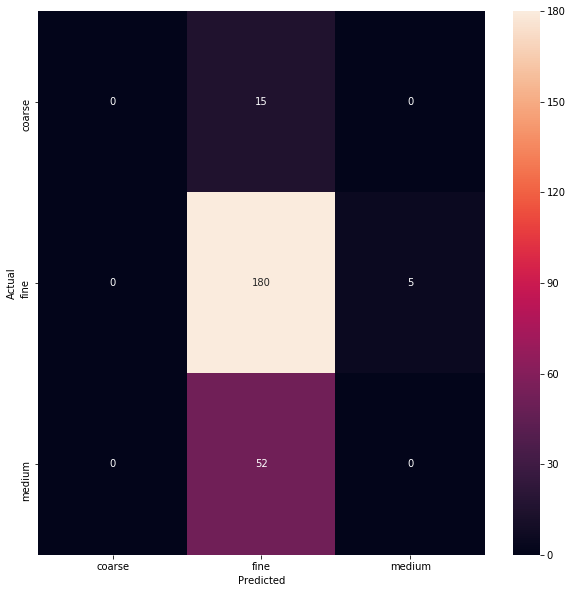

In [136]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=clean_texture_products_df.texture.unique(), yticklabels=clean_texture_products_df.texture.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [88]:
clean_texture_products_df.texture.value_counts()

fine      587
medium    136
coarse     40
Name: texture, dtype: int64

### Density Model 

In [139]:
clean_density_products_df = products_df.dropna(axis=0, how='any', subset=['density'])
print(clean_density_products_df.shape)
clean_density_products_df.head(20)

(819, 6)


,curl_pattern,density,porosity,texture,products,relevant_products
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl
17,3b,thick,low,coarse,my hair strands virgin hair armpit length cu...,tresemme
25,3a,thick,normal,medium,co wash suave naturals lavender co rinse natu...,suave aussie
38,2a,thin,normal,fine,text i k font going back and forth between he...,la grow herbal not aussie
40,3b,thin,normal,NaN,just started this natural hair journey have lo...,love suave
41,3c,thin,normal,NaN,just started this natural hair journey have lo...,love suave
49,4a,thin,NaN,NaN,i m down for anyg that s natural none of that...,design as got
50,4b,thin,NaN,NaN,i m down for anyg that s natural none of that...,design as got


In [143]:

clean_density_products_df['density_catagory'] = pd.Categorical(clean_density_products_df.density)
clean_density_products_df["density_catagory"] = clean_density_products_df["density_catagory"].cat.codes
print(clean_density_products_df.describe())
clean_density_products_df.head()

       density_catagory
count        819.000000
mean           1.238095
std            0.742173
min            0.000000
25%            1.000000
50%            1.000000
75%            2.000000
max            2.000000


,curl_pattern,density,porosity,texture,products,relevant_products,density_catagory
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as,1
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as,1
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl,0
17,3b,thick,low,coarse,my hair strands virgin hair armpit length cu...,tresemme,1
25,3a,thick,normal,medium,co wash suave naturals lavender co rinse natu...,suave aussie,1


In [144]:


density_catagory_df = clean_density_products_df[['density', 'density_catagory']].drop_duplicates().sort_values('density_catagory')
density_cat_key_dict = dict(density_catagory_df.values)
density_pattern_key_dict = dict(density_catagory_df[['density_catagory', 'density']].values)
print(density_cat_key_dict)
print(density_pattern_key_dict)
density_catagory_df

{'medium': 0, 'thick': 1, 'thin': 2}
{0: 'medium', 1: 'thick', 2: 'thin'}


,density,density_catagory
12,medium,0
4,thick,1
38,thin,2


In [145]:
X_train, X_test, y_train, y_test = train_test_split(clean_density_products_df['relevant_products'], clean_density_products_df['density'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
features = count_vect.fit_transform(clean_density_products_df.relevant_products).toarray()
labels = clean_density_products_df.density

In [146]:
from sklearn.metrics import precision_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    #precisions = cross_val_score(model, features, labels, scoring='precision_weighted', cv=CV)
    f1 = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, f1s in enumerate(f1):
        entries.append((model_name, fold_idx, f1s))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])
cv_df.groupby('model_name').f1.mean()

model_name
LinearSVC                 0.390753
LogisticRegression        0.394600
MultinomialNB             0.386590
RandomForestClassifier    0.335170
Name: f1, dtype: float64

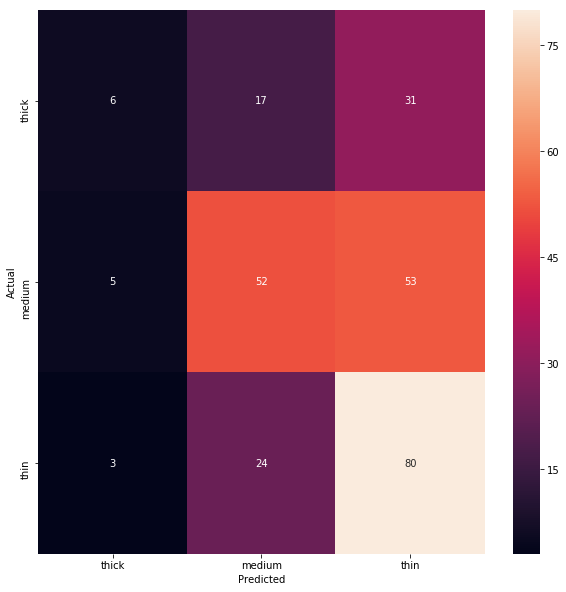

In [147]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=clean_density_products_df.density.unique(), yticklabels=clean_density_products_df.density.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [148]:
clean_density_products_df.density.value_counts()

thin      346
thick     322
medium    151
Name: density, dtype: int64

### Porosity Model 

In [149]:
clean_porosity_products_df = products_df.dropna(axis=0, how='any', subset=['porosity'])
print(clean_porosity_products_df.shape)
clean_porosity_products_df.head(20)

(747, 6)


,curl_pattern,density,porosity,texture,products,relevant_products
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl
17,3b,thick,low,coarse,my hair strands virgin hair armpit length cu...,tresemme
25,3a,thick,normal,medium,co wash suave naturals lavender co rinse natu...,suave aussie
38,2a,thin,normal,fine,text i k font going back and forth between he...,la grow herbal not aussie
40,3b,thin,normal,NaN,just started this natural hair journey have lo...,love suave
41,3c,thin,normal,NaN,just started this natural hair journey have lo...,love suave


In [150]:

clean_porosity_products_df['porosity_catagory'] = pd.Categorical(clean_porosity_products_df.porosity)
clean_porosity_products_df["porosity_catagory"] = clean_porosity_products_df["porosity_catagory"].cat.codes
print(clean_porosity_products_df.describe())
clean_porosity_products_df.head()

       porosity_catagory
count         747.000000
mean            1.115127
std             0.798876
min             0.000000
25%             0.000000
50%             1.000000
75%             2.000000
max             2.000000


,curl_pattern,density,porosity,texture,products,relevant_products,porosity_catagory
4,2c,thick,high,fine,mostly with some and a very strange curl wave...,suave as,0
5,3a,thick,high,fine,mostly with some and a very strange curl wave...,suave as,0
10,2b,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living,0
11,2c,NaN,high,fine,very hair low poo living proof restore shampo...,ouidad living,0
12,2c,medium,high,fine,wavy fii on the fia system current products l...,nexxus suave system jessicurl,0


In [151]:


porosity_catagory_df = clean_porosity_products_df[['porosity', 'porosity_catagory']].drop_duplicates().sort_values('porosity_catagory')
porosity_cat_key_dict = dict(porosity_catagory_df.values)
porosity_pattern_key_dict = dict(porosity_catagory_df[['porosity_catagory', 'porosity']].values)
print(porosity_cat_key_dict)
print(porosity_pattern_key_dict)
porosity_catagory_df

{'high': 0, 'low': 1, 'normal': 2}
{0: 'high', 1: 'low', 2: 'normal'}


,porosity,porosity_catagory
4,high,0
17,low,1
25,normal,2


In [152]:
X_train, X_test, y_train, y_test = train_test_split(clean_porosity_products_df['relevant_products'], clean_porosity_products_df['porosity'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
features = count_vect.fit_transform(clean_porosity_products_df.relevant_products).toarray()
labels = clean_porosity_products_df.porosity

In [153]:
from sklearn.metrics import precision_score
#precision_score(df.actual_label.values, df.predicted_RF.values)
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    #precisions = cross_val_score(model, features, labels, scoring='precision_weighted', cv=CV)
    f1 = cross_val_score(model, features, labels, scoring='f1_weighted', cv=CV)
    for fold_idx, f1s in enumerate(f1):
        entries.append((model_name, fold_idx, f1s))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])
cv_df.groupby('model_name').f1.mean()

model_name
LinearSVC                 0.394617
LogisticRegression        0.392574
MultinomialNB             0.396452
RandomForestClassifier    0.333295
Name: f1, dtype: float64

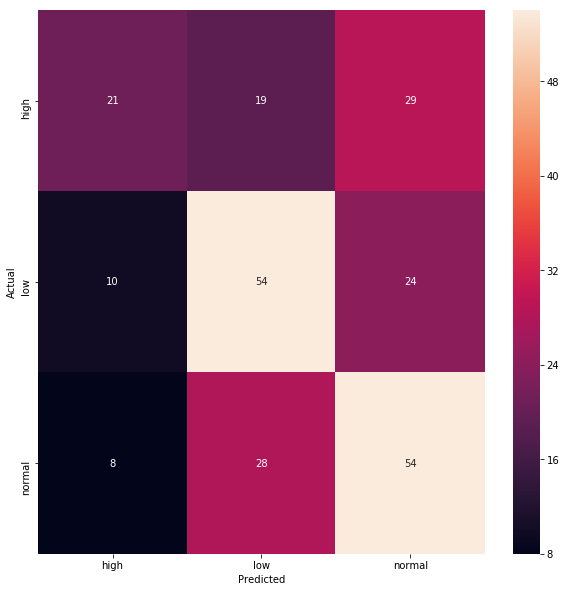

In [154]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=clean_porosity_products_df.porosity.unique(), yticklabels=clean_porosity_products_df.porosity.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [155]:
clean_porosity_products_df.porosity.value_counts()

normal    286
low       261
high      200
Name: porosity, dtype: int64